<a href="https://colab.research.google.com/github/bishair/Pirna/blob/main/G10PirnaCopy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display
import joblib


In [3]:
uploaded_file = files.upload()

Saving groundwater.xlsx to groundwater.xlsx


In [4]:
# Read the groundwater level data
gw_data = pd.read_excel('groundwater.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
print(gw_data)

# Read the river water level data
river_data = pd.read_excel('riverL.xlsx')
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%d/%m/%Y %H:%M')

# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

resampled_data = merged_data.resample('H').ffill()
resampled_data = resampled_data[1:]
print(resampled_data)

'''
has_nan = resampled_data.isna().any().any()
print(has_nan)
total_nan_count = resampled_data.isna().sum().sum()
print(total_nan_count)
nan_per_column = resampled_data.isna().any()
print(nan_per_column)
nan_count_per_column = resampled_data.isna().sum()
print(nan_count_per_column)'''


                     Date      G10
0     2015-01-30 12:18:00  110.722
1     2015-01-30 13:18:00  110.720
2     2015-01-30 14:18:00  110.718
3     2015-01-30 15:18:00  110.715
4     2015-01-30 16:18:00  110.714
...                   ...      ...
17533 2017-01-30 10:19:00  109.456
17534 2017-01-30 11:19:00  109.455
17535 2017-01-30 12:19:00  109.456
17536 2017-01-30 13:19:00  109.457
17537 2017-01-30 14:19:00  109.459

[17329 rows x 2 columns]
                         G10  River
Date                               
2015-01-30 13:00:00  110.722  261.0
2015-01-30 14:00:00  110.720  260.0
2015-01-30 15:00:00  110.718  260.0
2015-01-30 16:00:00  110.715  260.0
2015-01-30 17:00:00  110.714  260.0
...                      ...    ...
2017-01-30 10:00:00  109.457  135.0
2017-01-30 11:00:00  109.456  136.0
2017-01-30 12:00:00  109.455  138.0
2017-01-30 13:00:00  109.456  141.0
2017-01-30 14:00:00  109.457  144.0

[17546 rows x 2 columns]


'\nhas_nan = resampled_data.isna().any().any()\nprint(has_nan)\ntotal_nan_count = resampled_data.isna().sum().sum()\nprint(total_nan_count)\nnan_per_column = resampled_data.isna().any()\nprint(nan_per_column)\nnan_count_per_column = resampled_data.isna().sum()\nprint(nan_count_per_column)'

In [5]:
n_steps = 24

# Split the original data first before scaling
train_size = int(len(resampled_data) * 0.7)
resampled_data_train = resampled_data[:train_size]
resampled_data_test = resampled_data[train_size:]

# Apply MinMaxScaler only to the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(resampled_data_train)
test_scaled = scaler.transform(resampled_data_test)

joblib.dump(scaler, 'scaler.gz')


# Function to create sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for training and testing sets
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# Print shapes of X_train, y_train, X_test, y_test for verification
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)


X_train shape: (12258, 24, 2)
y_train shape: (12258,)
X_test shape: (5240, 24, 2)
y_test shape: (5240,)


In [7]:
print(X_train, X_train.shape)

[[[0.8510427  0.66666667]
  [0.85004965 0.66287879]
  [0.8490566  0.66287879]
  ...
  [0.83366435 0.65909091]
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]]

 [[0.85004965 0.66287879]
  [0.8490566  0.66287879]
  [0.84756703 0.66287879]
  ...
  [0.8326713  0.65909091]
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]]

 [[0.8490566  0.66287879]
  [0.84756703 0.66287879]
  [0.84707051 0.66287879]
  ...
  [0.83118173 0.66287879]
  [0.83118173 0.66666667]
  [0.82969215 0.67045455]]

 ...

 [[0.34011917 0.25757576]
  [0.33912612 0.25757576]
  [0.33813307 0.25757576]
  ...
  [0.32025819 0.23863636]
  [0.31926514 0.23863636]
  [0.3182721  0.23863636]]

 [[0.33912612 0.25757576]
  [0.33813307 0.25757576]
  [0.33714002 0.25757576]
  ...
  [0.31926514 0.23863636]
  [0.3182721  0.23863636]
  [0.31777557 0.23863636]]

 [[0.33813307 0.25757576]
  [0.33714002 0.25757576]
  [0.33614697 0.25757576]
  ...
  [0.3182721  0.23863636]
  [0.31777557 0.23863636]
  [0.31727905 0.23863636]]] (12258, 24

In [8]:
print(X_test, X_test.shape)

[[[0.31578947 0.23484848]
  [0.31479643 0.23484848]
  [0.31479643 0.23484848]
  ...
  [0.2979146  0.23106061]
  [0.29940417 0.23106061]
  [0.30139027 0.23106061]]

 [[0.31479643 0.23484848]
  [0.31479643 0.23484848]
  [0.31380338 0.23863636]
  ...
  [0.29940417 0.23106061]
  [0.30139027 0.23106061]
  [0.30585899 0.23106061]]

 [[0.31479643 0.23484848]
  [0.31380338 0.23863636]
  [0.31330685 0.23106061]
  ...
  [0.30139027 0.23106061]
  [0.30585899 0.23106061]
  [0.30834161 0.23106061]]

 ...

 [[0.24428997 0.21590909]
  [0.2428004  0.21212121]
  [0.2428004  0.20833333]
  ...
  [0.224429   0.18181818]
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]]

 [[0.2428004  0.21212121]
  [0.2428004  0.20833333]
  [0.24230387 0.20454545]
  ...
  [0.22293942 0.18939394]
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]]

 [[0.2428004  0.20833333]
  [0.24230387 0.20454545]
  [0.24180735 0.1969697 ]
  ...
  [0.2224429  0.19318182]
  [0.22194638 0.20075758]
  [0.2224429  0.21212121]]] (5240, 24,

In [9]:
print(y_train, y_train.shape)

[0.83118173 0.82969215 0.82969215 ... 0.31777557 0.31727905 0.316286  ] (12258,)


In [11]:
print(y_test, y_test.shape)

[0.30585899 0.30834161 0.31330685 ... 0.22194638 0.2224429  0.22293942] (5240,)


In [12]:
input_shape=(X_train.shape[1], X_train.shape[2])

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape,   #input shape => (timesteps, features).  X => (samples, timesteps, features)
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)


Epoch 1/50
192/192 [==============================] - 21s 65ms/step - loss: 0.1438
Epoch 2/50
192/192 [==============================] - 13s 65ms/step - loss: 0.0091
Epoch 3/50
192/192 [==============================] - 13s 69ms/step - loss: 0.0067
Epoch 4/50
192/192 [==============================] - 13s 67ms/step - loss: 0.0057
Epoch 5/50
192/192 [==============================] - 13s 68ms/step - loss: 0.0052
Epoch 6/50
192/192 [==============================] - 14s 73ms/step - loss: 0.0046
Epoch 7/50
192/192 [==============================] - 13s 67ms/step - loss: 0.0043
Epoch 8/50
192/192 [==============================] - 13s 68ms/step - loss: 0.0042
Epoch 9/50
192/192 [==============================] - 13s 68ms/step - loss: 0.0041
Epoch 10/50
192/192 [==============================] - 15s 76ms/step - loss: 0.0038
Epoch 11/50
192/192 [==============================] - 14s 73ms/step - loss: 0.0038
Epoch 12/50
192/192 [==============================] - 13s 68ms/step - loss: 0.0036
E

In [13]:
model.save('lstmmodel.h5')
model = load_model('lstmmodel.h5')
scaler = joblib.load('scaler.gz')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Function to retrain the model with new data
def retrain_model(model, X_new, y_new, epochs=5, batch_size=32):
    # Partial retraining of the model with new data
    model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, shuffle=True)
    return model

# Function to update y_train and recalculate statistics
def update_training_data(new_data, y_train, max_length=10000):
    updated_y_train = np.append(y_train, new_data)
    if len(updated_y_train) > max_length:
        updated_y_train = updated_y_train[-max_length:]
    mean_y_train = np.mean(updated_y_train)
    std_y_train = np.std(updated_y_train)
    return updated_y_train, mean_y_train, std_y_train

In [15]:
from scipy.stats import percentileofscore
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


actual_values = []
predicted_values = []
anomalies = []

# Initial mean and standard deviation
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)
threshold = 3  # Anomaly detection threshold


for i in range(X_test.shape[0]):
    X_input = X_test[i, :, :]       #selecting a single sequence from X_test, X_input  have the shape [timesteps, features] => (24, 2)
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))    #LSTM models  expect input in the form of 3D array [batch_size, timesteps, features] => (1, 24, 2)

    # Make a prediction and store prediction in predicted_values array
    forecast = model.predict(X_input)     #shapeof forecast => (1 timesequence of 24 steps,1 feature) => e.g [[0.28847086]]
    dummy_forecast = np.zeros((1, 2))
    dummy_forecast[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy_forecast)[0, 0]
    predicted_values.append(forecasted_value)    #Forecasted value => e.g 109.58


    # Process observed values for comparison and store in actual_values array
    if i < len(y_test):
        actual = y_test[i]    #fetching the observed value corresponding to the i-th sequence in X_test
        dummy_actual = np.zeros((1, 2))
        dummy_actual[:, 0] = actual
        actual_transformed = scaler.inverse_transform(dummy_actual)[0, 0]
        actual_values.append(actual_transformed)        #Observed value => e.g 109.639

        if np.abs(actual_transformed - mean_y_train) > threshold * std_y_train:
            print(f"Significant change detected at index {i}, triggering retraining.")
            model = retrain_model(model, X_train, y_train)  # Retrain the model
            y_train, mean_y_train, std_y_train = update_training_data(y_test[i], y_train)  # Update y_train

        if anomaly_detected:
          # Preprocess new data for model retraining
          #X_new, y_new = preprocess_new_data(new_data)  # You should define this function based on your data preprocessing steps
          # Retrain the model with new data
          X_new, y_new = X_test[:i+1, :, :], y_test[:i+1]  # Use data up to the current point
          model = retrain_model(model, X_new, y_new, epochs=additional_epochs, batch_size=batch_size)
          # Update y_train with the new data and recalculate statistics
          y_train, mean_y_train, std_y_train = update_training_data(y_test[i], y_train)

        # Update the plot
        ax.clear()
        ax.plot(actual_values, label='Observed', color='blue')
        ax.plot(predicted_values, label='Predicted', color='red')
        ax.set_title('Groundwater Level Prediction')
        ax.set_xlabel('Hours')
        ax.set_ylabel('Water Level')
        ax.legend()
        display(fig)
        plt.pause(0.5)
        clear_output(wait=True)


plt.close(fig)




1/1 [==============================] - 1s 505ms/step
Significant change detected at index 0, triggering retraining.
Epoch 1/5
384/384 [==============================] - 26s 58ms/step - loss: 0.0028
Epoch 2/5
384/384 [==============================] - 22s 58ms/step - loss: 0.0028
Epoch 3/5
384/384 [==============================] - 21s 54ms/step - loss: 0.0029
Epoch 4/5
 57/384 [===>..........................] - ETA: 20s - loss: 0.0030

KeyboardInterrupt: 

1/1 [==============================] - 0s 29ms/step


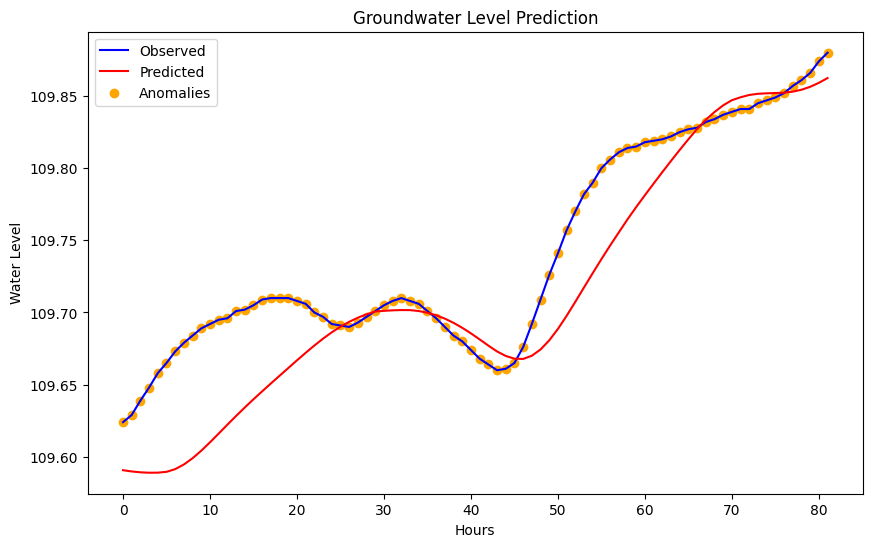

KeyboardInterrupt: 

In [ ]:
'''from scipy.stats import percentileofscore
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


print("y_train range: min =", np.min(y_train), ", max =", np.max(y_train))


fdc_percentiles = np.percentile(y_train, np.arange(0, 101, 1))


actual_values = []
predicted_values = []
anomalies = []


fig, ax = plt.subplots(figsize=(10, 6))

for i in range(X_test.shape[0]):
    # Select the i-th sample from X_test
    X_input = X_test[i, :, :]
    X_input = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

    # Make a prediction
    forecast = model.predict(X_input)
    dummy_forecast = np.zeros((1, 2))
    dummy_forecast[:, 0] = forecast[:, 0]
    forecasted_value = scaler.inverse_transform(dummy_forecast)[0, 0]
    predicted_values.append(forecasted_value)

    # Process actual values for comparison
    if i < len(y_test):
        actual = y_test[i]
        dummy_actual = np.zeros((1, 2))
        dummy_actual[:, 0] = actual
        actual_transformed = scaler.inverse_transform(dummy_actual)[0, 0]
        actual_values.append(actual_transformed)

        # Determine the percentile of the prediction in the FDC
        prediction_percentile = percentileofscore(fdc_percentiles, forecasted_value)
        if prediction_percentile < 5 or prediction_percentile > 95:
            anomalies.append(i)

    # Update the plot
    ax.clear()
    ax.plot(actual_values, label='Observed', color='blue')
    ax.plot(predicted_values, label='Predicted', color='red')
    if anomalies:
        ax.scatter(anomalies, [actual_values[j] for j in anomalies], color='orange', label='Anomalies')
    ax.set_title('Groundwater Level Prediction')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Water Level')
    ax.legend()
    display(fig)
    plt.pause(0.5)
    clear_output(wait=True)

plt.close(fig)

forecasted_values = np.array(predicted_values)
print("Forecasted range: min =", np.min(forecasted_values), ", max =", np.max(forecasted_values))'''


